**BenchMark** </br>


**1. Load and handle time series** </br>

In [63]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [14]:
data = pd.read_csv('AirPassengers.csv',
                   parse_dates=[0],
                   index_col=0,
                   squeeze=True)
data.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

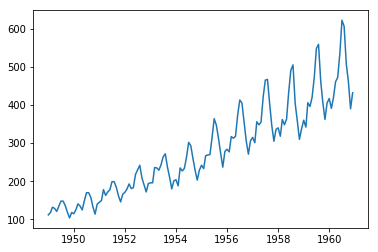

In [15]:
plt.plot(data)

It is clearly evident that there is an overall increasing trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences. So, more formally, we can check stationarity using the following: </br>

1. Plotting Rolling Statistics: plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.
2. Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’ (0.05), we can reject the null hypothesis and say that the series is stationary. 

**2. check on stationarity using rolling statics and Dickey-Fuller Test**

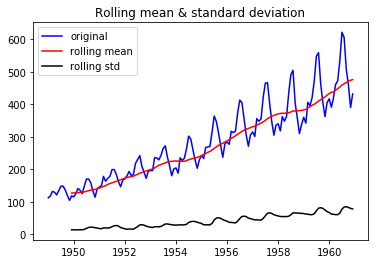

Test Statistics             0.815369
p-value                     0.991880
number of lags             13.000000
number of observations    130.000000
dtype: float64


In [24]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    # rolling statistics
    # roll_mean = pd.rolling_mean(timeseries, window=12)
    roll_mean = timeseries.rolling(12).mean()
    # roll_std  = pd.rolling_std(timeseries, window=12)
    roll_std = timeseries.rolling(12).std()
    
    # plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='original')
    mean = plt.plot(roll_mean, color='red',  label='rolling mean')
    std  = plt.plot(roll_std, color='black', label='rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean & standard deviation')
    plt.show(block=True)
    
    # perform Dickey-Fuller test
    df_test = adfuller(timeseries, autolag='AIC')
    df_output = pd.Series(df_test[0:4], index=['Test Statistics',
                                               'p-value',
                                               'number of lags',
                                               'number of observations'])
    print(df_output)
    
test_stationarity(data)

**Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series.**

**Make a time series stationary**
1. trend - varing mean over time. To reduce trend, we could do transformation, aggregation, smoothing (moving average) and polynomial fitting. </br>
2. seasonality - variations at specific time-frames. 

**Transformation - log transform**

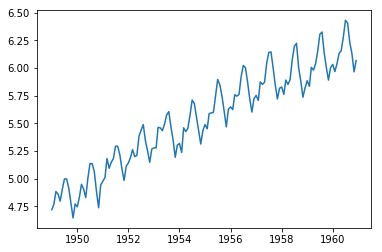

In [25]:
ts_log = np.log(data)
plt.plot(ts_log)

**1. Smoothing - moving average**

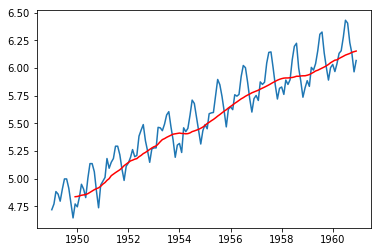

In [27]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

The red line above shows the rolling mean. Not that since we are taking average of last 12 values, rolling mean is not defined for the first 11 values. so we are going to drop the first 11 NaN values and check the stationary from the 12th point.

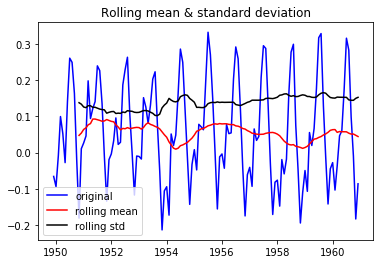

Test Statistics            -3.162908
p-value                     0.022235
number of lags             13.000000
number of observations    119.000000
dtype: float64


In [30]:
ts_log_moving_avg_diff = ts_log - moving_avg
# ts_log_moving_avg_diff
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

This seems like a much better series. The rolling values appear to be varying slightly but there is no specific trend. Also the p-value is small than 5% critical values so we can say with 95% confidence that this is a stationary series.

**1. [Exponentially weighted moving average](http://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html)**

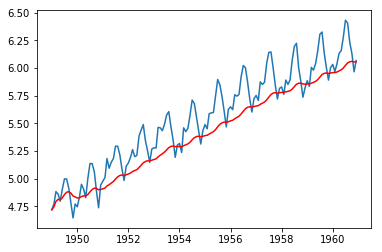

In [39]:
expw_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expw_avg, color='red')

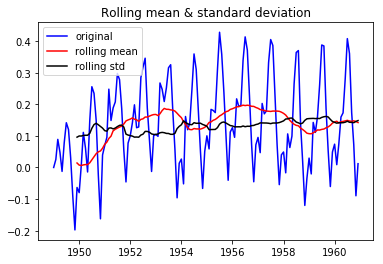

Test Statistics            -3.601262
p-value                     0.005737
number of lags             13.000000
number of observations    130.000000
dtype: float64


In [40]:
ts_log_ewm_diff = ts_log - expw_avg
test_stationarity(ts_log_ewm_diff)

This TS has even less variations in mean and standard deviation in magnitude. Also p-value < 0.05. Note in the case there will be no missing values as all values from starting are given weights. 

**Eliminating Trend and Stationality** </br>
The simple trend reduction techniques discussed before don't work in all cases, particularly the ones with high seasonality. 
1. Differencing - take the difference with a particular time lag
2. Decomposition - model both trend and seasonality and remove them from the model

**Differencing**

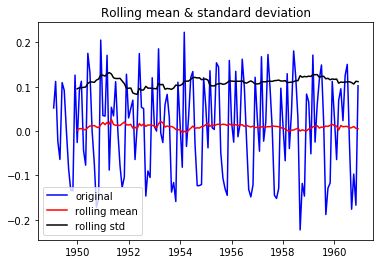

Test Statistics            -2.717131
p-value                     0.071121
number of lags             14.000000
number of observations    128.000000
dtype: float64


In [58]:
ts_log_diff = ts_log - ts_log.shift(periods=1)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

**Decomposing**

In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned. 

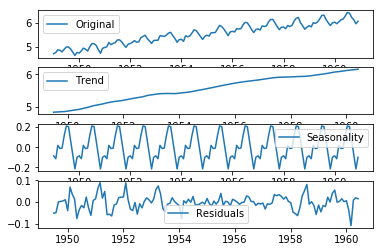

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
# plt.tight_layout()

**Forecasting a Time Series**

Here we are going to use **ARIMA** forecasting and we need number of AR terms(p), number of MA terms(q) and number of differences(d). </br>
In order to determine the value of p and q, we should use **ACF**(autocorrelation function) and **PACF**(partical autocorrelation function). </br>

/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


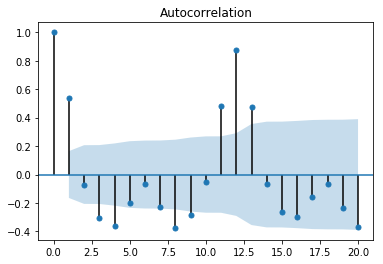

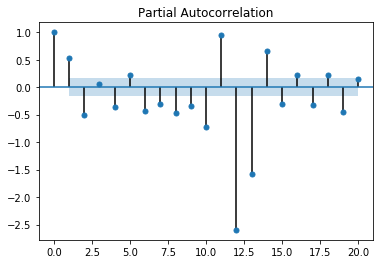

In [52]:
# ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log_diff, lags=20)
plot_pacf(ts_log_diff, lags=20)
plt.show()

**Fine tuning using Grid Search**

In [57]:
p, d, q = range(1,3), range(1,3), range(1,3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
seasonal_pdq

[(1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 2, 1, 12),
 (2, 2, 2, 12)]

In [64]:
import statsmodels.api as sm

def grid_search():
    warnings.filterwarnings("ignore")
    aic_accuracy = {}
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                module = sm.tsa.statespace.SARIMAX(ts_log_diff,
                                          order=param,
                                          seasonal_order=param_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
                results = module.fit()
                name = param + param_seasonal
                aic_accuracy[name] = results.aic
                print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return aic_accuracy

In [65]:
accuracy = grid_search()

SARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-416.09773025776923
SARIMA(1, 1, 1)x(1, 1, 2, 12)12 - AIC:-386.2470097879653
SARIMA(1, 1, 1)x(1, 2, 1, 12)12 - AIC:-342.56409586755024
SARIMA(1, 1, 1)x(1, 2, 2, 12)12 - AIC:-315.3930001621407
SARIMA(1, 1, 1)x(2, 1, 1, 12)12 - AIC:-383.5832883675615
SARIMA(1, 1, 1)x(2, 1, 2, 12)12 - AIC:-379.18752580057776
SARIMA(1, 1, 1)x(2, 2, 1, 12)12 - AIC:-315.5754602776251
SARIMA(1, 1, 1)x(2, 2, 2, 12)12 - AIC:-308.9263808498066
SARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:-419.04362030646683
SARIMA(1, 1, 2)x(1, 1, 2, 12)12 - AIC:-385.08981806370946
SARIMA(1, 1, 2)x(1, 2, 1, 12)12 - AIC:-339.4325643735399
SARIMA(1, 1, 2)x(1, 2, 2, 12)12 - AIC:-315.7363774460862
SARIMA(1, 1, 2)x(2, 1, 1, 12)12 - AIC:-382.7410407169312
SARIMA(1, 1, 2)x(2, 1, 2, 12)12 - AIC:-375.20217011654836
SARIMA(1, 1, 2)x(2, 2, 1, 12)12 - AIC:-315.2765729836337
SARIMA(1, 1, 2)x(2, 2, 2, 12)12 - AIC:-284.1069927450066
SARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:-348.90184297564065
SARIMA(1, 2, 1)x(1, 1, 2

In [68]:
print("Model with Minimum AIC {}".format(min(accuracy, key=accuracy.get)))

Model with Minimum AIC (1, 1, 2, 1, 1, 1, 12)


**Fit the model**

In [69]:
model = sm.tsa.statespace.SARIMAX(ts_log_diff,
                                  order=(1, 1, 2),
                                  seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
result = model.fit()
print(result.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        #Passengers   No. Observations:                  143
Model:             SARIMAX(1, 1, 2)x(1, 1, 1, 12)   Log Likelihood                 215.522
Date:                            Wed, 15 May 2019   AIC                           -419.044
Time:                                    14:39:38   BIC                           -402.574
Sample:                                02-01-1949   HQIC                          -412.359
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1301      0.212      0.615      0.539      -0.285       0.545
ma.L1         -1.5508     19.231   

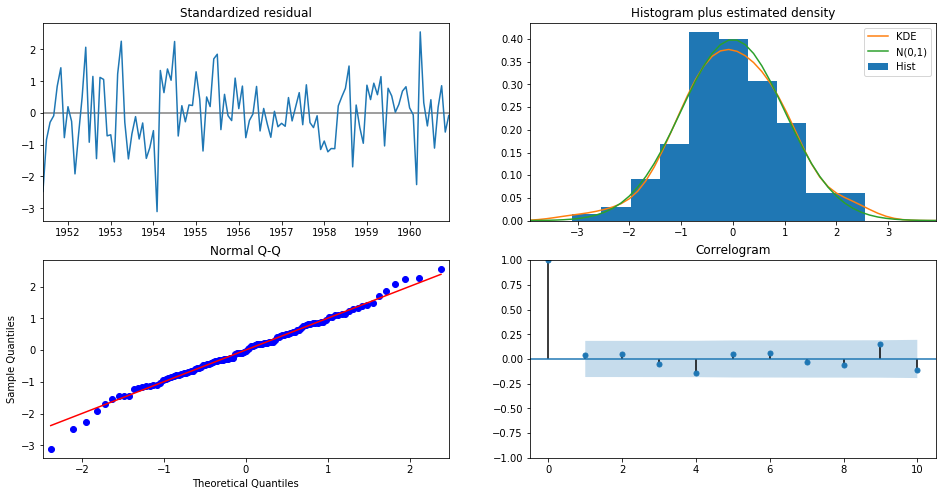

In [70]:
result.plot_diagnostics(figsize=(16, 8))
plt.show()